<h1><center> ROAD SURFACE TEMPERATURE ANALYSIS </center></h1>

<center> <b>Influence of weather on road conditions for self driving cars <b> </center>
<center> ECON 323 PROJECT  </center>

*Authors: Martina Chiesa and Pascal Terpstra*

# Index

[Introduction](#Introduction)

[Objective and method](#Objective-and-method)

[Libraries](#Libraries)

[Data](#Data)

[Data Exploration](#Data-Exploration)

- [Univariate statistics](#Univariate-statistics)

- [Missing value imputation](#Missing-value-imputation)

- [Date time](#Date-time)

- [Road Surface Temperature graph ](#Road-Surface-Temperature-graph)

- [Road Surface Temperature in a day](#Road-Surface-Temperature-in-a-day)

- [Temperature in a day](#Temperature-in-a-day)

[Regression models](#Regression-models)

- [Linear regression](#Linear-regression)
    - [Prediction RST at 2pm](#Prediction-RST-at-2pm)
    - [Prediction RST at 10pm](#Prediction-RST-at-10pm)
- [Lasso regression](#Lasso-regression)
    - [Lasso RST at 2pm](#Lasso-RST-at-2pm)
    - [Lasso RST at 10pm](#Lasso-RST-at-10pm)

[Build a new dataframe for classification](#Build-a-new-dataframe-for-classification)
 - [Adding response variable](#Adding-response-variable)
 
[Pre processing](#Pre-processing)
- [Split in train and test sets](#Split-in-train-and-test-sets)
- [Feature scaling](#Feature-scaling)

[Classification analysis](#Classification-analysis)
- [Logistic regression classifier](#Logistic-regression-classifier)
- [KNN](#KNN)
- [SVM linear](#SVM-linear)
- [SVM non linear](#SVM-non-linear)
- [Naive bayes classifier](#Naive-bayes-classifier)
- [Decision tree](#Decision-tree)
- [Random forest](#Random-forest)
- [Ada boost](#Ada-boost)

[Conclusions](#Conclusions)

## Introduction

In the context of the development of self-driving cars, it is relevant to be able to predict road surface temperature, since it highly influences the safety of roads and it is therefore important that cars adapt their driving style depending on the road conditions (*Sukuvaara, Timo, et al. "ITS-Enabled advanced road weather services and infrastructures for vehicle winter testing, professional traffic fleets and future automated driving." Proceedings of the 2018 ITS World Congress, Copenhagen, Denmark. 2018.*).

Autonomous vehicles can sense their surroundings and navigate without human intervention. Although promising and proving safety features, the trustworthiness of these cars has to be examined before they can be widely adopted on the road. Unlike traditional network
security, autonomous vehicles rely heavily on their sensory ability of their surroundings to make driving decision, which incurs a security risk from sensors.

However, these sensors can may not be so accurate yet, thus companies are also collecting weather data available from other sources, such as observations from Earth-orbiting satellites to evaluate the road condition and test the related car performance (*Wentz, Frank J., and Matthias Schabel. "Precise climate monitoring using complementary satellite data sets." Nature 403.6768 (2000): 414-416.*).


## Objective and method

Our main goal in this report is to predict road surface temperature - which is usually unknown - based on information about the weather such as air temperature and solar radiation.

Specifically we will perform two different types of analysis: 

- Regression

First, we will try to create models that can predict the road surface temperature using linear regression and lasso regularization. Self-driving cars may have to adapt their driving style based on the temperature of the road and since we are yet unable to measure the exact temperature of roads we will have to make decisions on the data that is accessible. In this case we are in possession of many predictors and we will therefore make use of lasso regularization to prevent overfitting. Next, we will fit a linear model on the predictors that are not dropped yet by the lasso regression, because lasso regression is a biased estimator of the true parameters.

- Classification

Then, we will focus on a classification tasks in which the real word application is not limited to automatic cars. Nowadays, also the current commercial vehicles are equipped with the Advanced Driver Assistance Systems (ADASs), which use an environment perception module consisted of several sensors whose objective is to provide relevant data necessary to interpret the surrounding scenes near the vehicle. In normal climatic conditions, the reliability and benefits of the ADASs have gained popularity and confidence. However, in adverse weather conditions, the experience of the driver is required to compensate for the failure of the ADASs to appropriately perceive the surrounding environment, which usually results in severe accidents. 
In particular when the road surface temperature is close to 0°C ice risk is verified. Thus, the ability to distinguish this situation from the others could be helpful in order to prevent accidents.

We identify the Risk class for days in which the temperature is in a range between 0°C + - standard deviation of the distribution of Road Surface Temperature mean.

Methods that will be used are: Logistic Regression, KNN, SVM, Naive Bayes classifier, Decision tree, Random Forest, Ada Boost.

We both work on all tasks, but mainly Pascal focused on regression and Martina on classification.

## Libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
import plotly.express as px
import seaborn as sb

from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import (linear_model, metrics, neural_network, pipeline, model_selection)
from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

import plotly.offline as pyo
pyo.init_notebook_mode()

## Data

In this report we will investigate a data set that contains information about weather and temperature of road surface at certain moments in time, namely for each hour of the day from November 1st 2017 until April 15th 2022 in the village Dollerup, Germany (coordinates: 6.6994,54.7717). 

In detail, each row corresponds to a day in which 24 values (one for each hour of the day) are collected for the following variables:

| Variable Name | Meaning |
| --- | --- |
| RST | Road Surface Temperature |
| TT | Air Temperature|
| TD | Dew Point Temperature|
| GRAD1 | Solar Radiation|
| NE | Effective Cloud Cover |
| FF | Wind Speed |

Furthermore, the time of the measurement of the variable is given at the end of the variable name. For example, RST_1000 represents the road surface temperature at 10am, and RST_1800 represents the same at 6pm.

In [42]:
#path = 'C:/Users/pasca/Documents/100356.csv'
path = 'C:/Users/chies/OneDrive/Desktop/ECON_323/project/100356.csv'
df = pd.read_csv(path)
df.head()

date  RST_0000  RST_0100  RST_0200  RST_0300  RST_0400  RST_0500  \
0  20171101       9.8       9.9      10.2      10.5      10.8      11.1   
1  20171102       NaN       NaN       NaN       NaN       NaN       NaN   
2  20171103       6.6       6.9       6.5       7.2       7.1       7.1   
3  20171104       8.6       8.6       8.6       8.5       8.5       8.5   
4  20171105       9.7      10.1      10.2       9.5       8.7       8.1   

   RST_0600  RST_0700  RST_0800  ...  FF_1400  FF_1500  FF_1600  FF_1700  \
0      11.2      11.5       NaN  ...     19.0     17.3     16.6     18.7   
1       NaN       NaN       8.6  ...     15.8     14.6     12.7     10.6   
2       7.0       7.6       8.6  ...      9.7     11.4     10.5     10.4   
3       8.4       8.6       9.0  ...      9.2      8.4     10.0     11.8   
4       8.1       7.5       8.3  ...      6.0      6.4      7.3      5.9   

   FF_1800  FF_1900  FF_2000  FF_2100  FF_2200  FF_2300  
0     18.0     20.2     20.3     22.1     21.3     19.7  
1      9.4     12.0      9.6      7.8      8.6      8.1  
2     10.5     11.1     11.0     12.4     11.6     12.1  
3     12.4     12.1     11.6      9.7     11.1     13.7  
4      5.9      6.2      6.6      5.2      6.4      8.0  

[5 rows x 145 columns]

## Data Exploration

### Univariate statistics

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Columns: 145 entries, date to FF_2300
dtypes: float64(144), int64(1)
memory usage: 1.1 MB


Tha dataset contains 145 columns and 1015 rows.

We present now summary statistics for each variable:

In [44]:
(df.drop(['date'], axis=1).describe())

RST_0000    RST_0100    RST_0200    RST_0300    RST_0400    RST_0500  \
count  976.000000  970.000000  971.000000  972.000000  970.000000  972.000000   
mean     4.359221    4.199897    4.082389    3.984053    3.933608    3.925823   
std      4.495237    4.476646    4.472077    4.482250    4.495215    4.494730   
min     -9.400000  -10.100000  -10.500000  -10.900000  -11.200000  -11.400000   
25%      1.200000    1.100000    0.900000    0.800000    0.800000    0.875000   
50%      4.000000    4.000000    3.700000    3.650000    3.600000    3.600000   
75%      7.100000    7.000000    6.800000    6.825000    6.800000    6.800000   
max     17.300000   17.000000   18.000000   18.000000   18.200000   18.100000   

         RST_0600    RST_0700    RST_0800    RST_0900  ...      FF_1400  \
count  975.000000  978.000000  978.000000  980.000000  ...  1015.000000   
mean     4.132718    4.644376    5.695603    7.058265  ...    12.703448   
std      4.483807    4.667251    5.134104    5.694181  ...     5.731249   
min    -11.500000  -11.600000  -10.600000   -8.500000  ...     1.000000   
25%      1.100000    1.700000    2.300000    3.300000  ...     8.600000   
50%      3.800000    4.500000    5.200000    6.100000  ...    12.000000   
75%      7.000000    7.500000    8.800000   10.400000  ...    16.000000   
max     18.100000   19.000000   20.900000   25.000000  ...    38.600000   

           FF_1500      FF_1600      FF_1700      FF_1800      FF_1900  \
count  1015.000000  1015.000000  1015.000000  1015.000000  1015.000000   
mean     12.437734    12.197734    12.011232    11.840690    11.739113   
std       5.733469     5.523552     5.376537     5.320602     5.236507   
min       0.900000     1.700000     1.900000     1.400000     1.100000   
25%       8.200000     8.100000     8.200000     8.150000     8.100000   
50%      11.600000    11.400000    11.200000    11.000000    11.000000   
75%      16.000000    15.400000    14.950000    14.800000    14.450000   
max      37.400000    35.600000    34.300000    35.000000    34.800000   

           FF_2000      FF_2100      FF_2200      FF_2300  
count  1015.000000  1015.000000  1015.000000  1015.000000  
mean     11.723054    11.639212    11.613793    11.617537  
std       5.265115     5.251522     5.277942     5.405816  
min       1.500000     1.900000     1.200000     1.100000  
25%       8.000000     8.000000     8.000000     7.900000  
50%      11.100000    11.000000    11.000000    10.800000  
75%      14.600000    14.600000    14.700000    14.900000  
max      34.900000    34.100000    33.800000    34.700000  

[8 rows x 144 columns]

It is possible to notice that the all the variable have approximately same scale and in general similar distributions. This was expected by the meaning of each variable. For example the distribution of the Air Temperature at 10am is expected to behave similarly to the same measure at 6pm. 

### Missing value imputation

Then we want to check if there are missing values:

In [45]:
df[df.isna().any(axis=1)]

date  RST_0000  RST_0100  RST_0200  RST_0300  RST_0400  RST_0500  \
0     20171101       9.8       9.9      10.2      10.5      10.8      11.1   
1     20171102       NaN       NaN       NaN       NaN       NaN       NaN   
7     20171108       2.6       3.6       4.0       3.4       4.0       4.2   
8     20171109       NaN       NaN       NaN       NaN       NaN       NaN   
9     20171110       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
984   20220316       3.5       3.1       2.3       2.2       2.7       2.8   
985   20220317       4.6       4.5       4.1       3.7       3.8       4.1   
993   20220325       NaN       NaN       4.2       NaN       NaN       3.2   
999   20220331       0.0       0.0       0.2       0.3       0.1       0.6   
1000  20220401       NaN       NaN       NaN       0.8       0.8       0.8   

      RST_0600  RST_0700  RST_0800  ...  FF_1400  FF_1500  FF_1600  FF_1700  \
0         11.2      11.5       NaN  ...     19.0     17.3     16.6     18.7   
1          NaN       NaN       8.6  ...     15.8     14.6     12.7     10.6   
7          5.3       5.6       6.1  ...      8.7      5.4      6.2      7.4   
8          NaN       NaN       NaN  ...     16.3     17.2     18.4     18.9   
9          NaN       NaN       NaN  ...     15.3     18.9     19.4     16.2   
...        ...       ...       ...  ...      ...      ...      ...      ...   
984        2.9       3.9       5.0  ...     11.7     13.0     11.5     14.1   
985        4.5       5.2       6.0  ...     17.2     15.6     16.4     13.0   
993        3.6       5.4      10.2  ...     11.3     12.6     12.4     11.2   
999        1.0       2.0       3.0  ...     18.9     18.1     16.8     16.8   
1000       1.6       3.2       5.4  ...     13.7     12.8     12.5     12.8   

      FF_1800  FF_1900  FF_2000  FF_2100  FF_2200  FF_2300  
0        18.0     20.2     20.3     22.1     21.3     19.7  
1         9.4     12.0      9.6      7.8      8.6      8.1  
7         6.3      6.1      7.2      6.7      6.9      5.4  
8         9.2      8.4     10.4      9.9     10.0     10.0  
9        16.1     15.0     13.5     16.5     13.0     16.0  
...       ...      ...      ...      ...      ...      ...  
984      14.5     13.6     13.4     14.9     15.6     16.3  
985      12.6     10.0     10.4      9.8      9.0      9.2  
993      10.5      9.2     10.5      9.1     10.2     10.2  
999      14.4     13.9     14.3     12.6     11.6     13.5  
1000     12.8     13.2     12.2     11.6     10.4      8.6  

[106 rows x 145 columns]

In [46]:
print("Total number of missing values in the dataframe:", df.isnull().sum().sum())

Total number of missing values in the dataframe: 1121


We chose to replace all missing values by its previous value, i.e. the value of the day before at the same time through the following function:

In [47]:
def missing(df):
    """ 
    input = dataframe
    fill missing values with the next observed value
    output = dataframe with no Nan
    """
    df = df.fillna(method="bfill")
    return df

In [48]:
df = missing(df)
#df.isnull().sum().sum() # to check that now is 0

### Date time

Date variable is read as numeric, so it is necessary to change the format of it.

In [49]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d') # convert to date time
df['date']

0      2017-11-01
1      2017-11-02
2      2017-11-03
3      2017-11-04
4      2017-11-05
          ...    
1010   2022-04-11
1011   2022-04-12
1012   2022-04-13
1013   2022-04-14
1014   2022-04-15
Name: date, Length: 1015, dtype: datetime64[ns]

### Road Surface Temperature graph 

To get a better idea of the mobility of the road surface temperature, we made a time series plot of the road surface temperature for each day at 2pm from 2017-11-01 until 2022-04-15.

In [50]:
example = pd.DataFrame(
    {
        "date": np.arange(len(df['RST_1400'])),
        "Road Service Temperature": df['RST_1400'],
    }
)
px.line(example, x="date", y="Road Service Temperature")

From the plot above we can observe and learn a lot. One can notice that the data is homogeneous in the sense that the road surface temperature is usually similar to the day(s) before it. Furthermore, there is a clear presence of seasonality, by noticing that some patterns are similar each day, such as the peeks in each summer.

### Road Surface Temperature in a day
In the graph below we plot the average road surface temperature for each hour of the day across all the data that we have. From this plot we can get a better idea of the amount of variation and whether there could be some intuitive explanation.

In [51]:
vRST = np.zeros(24)
for i in range(24):
    vRST[i] = df.iloc[:,1+i].mean()
example2 = pd.DataFrame(
    {
        "hour of day": np.arange(24),
        "Road Service Temperature": vRST,
    }
)
px.line(example2, x="hour of day", y="Road Service Temperature")

From the graph above we can see that the road surface temperature differs a lot across the day and we may suspect that there is a correlation between solar radiation and temperature with the road surface temperature, since the average road surface temperature is higher during the day and lower in the night. Furthermore, we can see that for each hour of the day we will probably have to make a seperate model, because the influence of the road surface temperature of the hours before strongly depends on the hour we focus on. For instance, if we know that it was 10 degrees at 11am we will probably predict an even higher temperature at 12pm, whereas if we know that the road surface temperature was 10 degrees at 3pm, we will predict a lower value for the road surface temperature at 4pm, i.e. the parameter value in a time series model will depend the hour of the day and we must therefore distinguish models depending on the hour.

### Temperature in a day

Now, we will make a plot of the average air temperature (TT) for each hour of the day to see whether there is a similarity in distribution with the road surface temperature as we expect.

In [52]:
vTT = np.zeros(24)
for i in range(24):
    vTT[i] = df.iloc[:,25+i].mean()
example2 = pd.DataFrame(
    {
        "hour of day": np.arange(24),
        "Temperature": vTT,
    }
)
px.line(example2, x="hour of day", y="Temperature")

From the plots above we can notice that the average road surface temperature and average temperature seem to have a very similar distribution, which indicates that temperature will be an important predictor.

# Prediction and classification analysis

## Regression models

In this section we predict the road surface temperature on a specific time, namely 2pm and 10pm using as predictors: TT, TD, GRAD1, NE and FF available at the current values of the predictors and ten lags. E.g. for 2pm the predictors will be from 8am until 2pm. 

First, we will use linear regression to get an idea of the predictive power of the model and to designate which variables are important predictors. Secondly, we will apply lasso regularization on the same predictors to delete the variables that are of no importance. To decide which value to use as tuning parameter in lasso regression we will make use of cross validation.

### Linear regression

The method we will try out first is linear regression which can be exploited by the following equation:
$y_i = \beta_0 + \beta_1 x_{i1} + ... + \beta_k x_{ik} + u_i \qquad (i = 1,2, ..., n)$

where the parameters are estimated by minimizing the squared loss as follows: $\hat{\beta} = \underset{\beta\in R^{k+1}}{\mathrm{argmin}}\sum_{i=1}^{n}{(y_i-X_i'\beta)^2}$.

The response variable $Y$ is the Road Surface Temperature at time 2pm firstly, then at 10pm.

#### Prediction RST at 2pm

In [53]:
def regression(df, hour, lags):
    """
    input: dataframe, hour for response, number of lags
    output: X matrix containing TT, TD, GRAD1, NE, FF up to a certain number of lags, 
            y vector containing RST for the given hour
    """
    X = pd.concat([pd.DataFrame(df.iloc[:, (df.columns.get_loc("TT_0000")+hour-lags):(df.columns.get_loc("TT_0000")+hour+1)]),
                  pd.DataFrame(df.iloc[:, (df.columns.get_loc("TD_0000")+hour-lags):(df.columns.get_loc("TD_0000")+hour+1)]),
                  pd.DataFrame(df.iloc[:, (df.columns.get_loc("GRAD1_0000")+hour-lags):(df.columns.get_loc("GRAD1_0000")+hour+1)]),
                  pd.DataFrame(df.iloc[:, (df.columns.get_loc("NE_0000")+hour-lags):(df.columns.get_loc("NE_0000")+hour+1)]),
                  pd.DataFrame(df.iloc[:, (df.columns.get_loc("FF_0000")+hour-lags):(df.columns.get_loc("FF_0000")+hour+1)])
                  ], axis=1)

    y = pd.DataFrame(df.iloc[:, df.columns.get_loc("RST_0000")+hour])
    return X,y

def lmodel(X,y):
    '''
    input: X matrix, y vector
    output: linear regression model summary on given input
    '''
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())

In [54]:
df = missing(df)

X1400,y1400 = regression(df, 14, 10)
lmodel(X1400,y1400)

                            OLS Regression Results                            
Dep. Variable:               RST_1400   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     443.9
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:26:25   Log-Likelihood:                -1743.7
No. Observations:                1015   AIC:                             3599.
Df Residuals:                     959   BIC:                             3875.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1230      0.329     -9.491      0.0

From the table above we can see that many variables are deemed insignificant ($P(x_i>|t|)>0.05$). The variables that are deemed most important seem to be the coefficients which have $P>|t| = 0:$   (TT1400), (GRAD1_1200) and (GRAD1_1400). Furtermore, the adjusted $R^2$ value of 0.960 implicates that we can explain most of the variation in road surface temperature.

#### Prediction RST at 10pm

In [55]:
X2200,y2200 = regression(df, 22, 10)
X2200
lmodel(X2200,y2200)

                            OLS Regression Results                            
Dep. Variable:               RST_2200   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     447.5
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:26:25   Log-Likelihood:                -1287.6
No. Observations:                1015   AIC:                             2685.
Df Residuals:                     960   BIC:                             2956.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8540      0.201    -14.231      0.0

The predictive performance of the linear regression model for 10pm is similar to the performance for 2pm, though we can notice that the parameter values are different. One thing that is interesting to notice is that solar radiation (GRAD1) was an important predictor for RST at 2pm but seems to be of no importance at 10pm, which makes sense, because there is no solar radiation around 10pm anymore. This stresses the importance to make distuinguished models for each hour of the day.

### Lasso regression

Since many of the variables that were included in the linear model are not relevant and should therefore be ommited, we will make use of lasso regularization, which not only minimizes the sum of squared residuals, but also adds a penalty term which prevents overfitting:

$\hat{\beta}_{lasso} = \underset{\beta}{\arg\min} \sum\limits_{i=1}^n (y_i-X_i'\beta)^2 + \lambda \sum\limits_{j=1}^p |\beta_{j}|$

Note that $\lambda$ determines the weight of the added penalty, meaning that $\lambda$ can be any value in the interval $[0, \infty)$. The benefit of using Lasso regularization is that the less contributing variables will be eliminated from the model. Thus, due to Lasso regularization the model will give more accurate predictions when applying it to out of sample predictions. We will make use of Cross-Validation (CV) to choose the tuning parameter $\lambda$. More specifically, we will use K-fold CV, which splits the data in K folds and leaves out one of the folds to train the model on all folds except one and make predictions on the left-out fold to estimate the Mean Squared Error (MSE) for a grid of $\lambda$ values.

In the code below we will apply lasso on the same predictors as in the linear regression models above.

#### Lasso RST at 2pm

In [56]:
def lassoReg(X,y):
    '''
    input: matrix X and response vector y
    output: dataframe containing MSE, estimated using CV, for all values of the alpha grid 0 until 1.
    '''
    n = 500
    #Creating alpha grid
    alphas = np.linspace(0.002,1,n)
    mse = np.zeros(n)
    X_train=X
    y_train=y
    
    #creating function that fits lasso regression model and returns MSE for same training set
    def fit_and_report_mses(mod, X_train, y_train):
        mod.fit(X_train, y_train)
        return metrics.mean_squared_error(y_train, mod.predict(X_train))

    msetrain = [np.mean(fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                               X_train, y_train))
                        for alpha in alphas]
    
    #Calculating estimated MSE on CV for alpha grid
    msecv = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                      X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
              for alpha in alphas]

    print('Optimal alpha: ', alphas[np.where(msecv==np.min(msecv))], 'with corresponding MSE: ', round(np.min(msecv),2))

    #Creating dataframe, which helps making a nice plot for alpha grid against its corresponding estimated MSE
    example3 = pd.DataFrame(
        {
            "Alpha": np.concatenate((alphas,alphas)),
            "MSE": np.concatenate((msecv,msetrain)),
            "cv-train": np.concatenate((np.repeat("CV", len(alphas)),np.repeat("Train", len(alphas))))
        }
    )
    return example3

In [57]:
import warnings
warnings.filterwarnings('ignore')
example3 = lassoReg(np.matrix(X1400),y1400)
px.line(example3, x="Alpha", y="MSE", color="cv-train")

Optimal alpha:  [0.048] with corresponding MSE:  2.19


The optimal lasso regression model for RST1400 seems to be for $\alpha=0.048$, since it minimizes the estimated MSE using CV. One can notice that the MSE on the training set is lower than on the left-out fold, which make sense intuitively.

In [58]:
lasso_model = Lasso(alpha=0.048).fit(X1400,y1400)
lasso_coefs = pd.Series(dict(zip(list(X1400), lasso_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs))
coefs

lasso
TT_0400     0.040399
TT_0500     0.000000
TT_0600     0.000000
TT_0700     0.175607
TT_0800     0.039599
TT_0900     0.000000
TT_1000     0.000000
TT_1100     0.000000
TT_1200     0.000000
TT_1300     0.068205
TT_1400     0.694896
TD_0400     0.000000
TD_0500    -0.000000
TD_0600    -0.000000
TD_0700     0.000000
TD_0800     0.000000
TD_0900    -0.000000
TD_1000    -0.049887
TD_1100    -0.000000
TD_1200    -0.000000
TD_1300    -0.000000
TD_1400     0.000000
GRAD1_0400  0.000000
GRAD1_0500  0.000000
GRAD1_0600 -0.005161
GRAD1_0700  0.004623
GRAD1_0800  0.002682
GRAD1_0900  0.002266
GRAD1_1000  0.006073
GRAD1_1100 -0.003775
GRAD1_1200  0.005764
GRAD1_1300  0.004337
GRAD1_1400  0.014364
NE_0400     0.012087
NE_0500     0.066627
NE_0600    -0.016707
NE_0700    -0.005721
NE_0800     0.045778
NE_0900     0.057771
NE_1000     0.000000
NE_1100     0.082545
NE_1200     0.040359
NE_1300     0.072016
NE_1400     0.143800
FF_0400    -0.020241
FF_0500     0.000000
FF_0600    -0.000000
FF_0700    -0.000000
FF_0800    -0.000000
FF_0900     0.002726
FF_1000     0.000000
FF_1100    -0.027617
FF_1200    -0.029053
FF_1300    -0.000000
FF_1400    -0.031354

The cell above provides us with the estimated parameter coefficients. The estimated coefficient values are absolutely lower than the values in the linear regression model. Furthermore, some coefficients are now set equal to 0 and are therefore deemed insignificant.

#### Lasso RST at 10pm

In [59]:
example4 = lassoReg(X2200,y2200)
px.line(example3, x="Alpha", y="MSE", color="cv-train")

Optimal alpha:  [0.044] with corresponding MSE:  0.84


The optimal lasso regression model for RST2200 seems to be for $\alpha=0.044$, since it minimizes the estimated MSE using cross-validation. Moreover, we can notice that many variables were set to 0 and thus deemed insiginificant.

In [60]:
lasso_model = Lasso(alpha=0.044).fit(X2200,y2200)
lasso_coefs = pd.Series(dict(zip(list(X2200), lasso_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs))
coefs

lasso
TT_1200     0.104730
TT_1300     0.000000
TT_1400     0.000000
TT_1500     0.000000
TT_1600     0.078908
TT_1700     0.000000
TT_1800     0.062059
TT_1900     0.000000
TT_2000     0.047117
TT_2100     0.000000
TT_2200     0.626788
TD_1200     0.000000
TD_1300     0.000000
TD_1400     0.000000
TD_1500    -0.000000
TD_1600     0.000000
TD_1700     0.000000
TD_1800     0.000000
TD_1900     0.000000
TD_2000     0.000000
TD_2100     0.000000
TD_2200     0.071725
GRAD1_1200  0.001877
GRAD1_1300  0.000171
GRAD1_1400  0.000075
GRAD1_1500  0.001163
GRAD1_1600  0.002237
GRAD1_1700  0.003312
GRAD1_1800  0.005909
GRAD1_1900  0.000000
GRAD1_2000 -0.000000
GRAD1_2100  0.000000
GRAD1_2200  0.000000
NE_1200     0.059796
NE_1300     0.000864
NE_1400     0.000000
NE_1500     0.000000
NE_1600     0.036876
NE_1700     0.037229
NE_1800    -0.000000
NE_1900     0.000000
NE_2000     0.013189
NE_2100     0.082416
NE_2200     0.183437
FF_1200    -0.000000
FF_1300    -0.000000
FF_1400    -0.034338
FF_1500     0.000000
FF_1600     0.000000
FF_1700     0.000000
FF_1800     0.000000
FF_1900     0.005986
FF_2000    -0.000000
FF_2100    -0.000000
FF_2200    -0.038410

Many variables are set to 0 for the corresponding lasso model. The most important predictor is TT_2200, the current temperature. Furthermore, NE seems to be an important factor as well, whereas GRAD1, FF and TD seem to be close to negligible.

# Classification analysis

In this section we want to conduct a classification analysis in which we are able to predict if a day has 'driving risk' or not, accordingly to the other variables (air temperature, dew point temperature, solar radiation, effective cloud cover, wind speed).

Thus, we firstly code a new binary output variable which represents the risk. Thus, we are not interested anymore in the hourly values, so we consider the daily mean of the road surface temperature in a day (given by the mean by row of the 24 columns RST). If this value is close to 0 means that driving could be risky on that day. 

As techniques we will apply several machine learning algorithms to classify that variable. 
In order to do so, we create a new dataframe which summaries for each day the information regarding each of these variables (TT, TD, GRAD1, NE, FF). Specifically, to summarise them in an informative and compact representation we generate new features (std, skewness, min, max, ...).
This method generates a large set of candidate features by combining information in the original features, with the aim of maximizing predictive performance.

## Build a new dataframe for classification

Functions for feature generation:

In [61]:
from scipy import stats 
def mean(x):
    return np.mean(x)
def std(x):
    return np.std(x)
def ptp(x):
    return np.ptp(x)
def variance(x):
    return np.var(x)
def minim(x):
    return np.min(x)
def maxim(x):
    return np.max(x)
def argminim(x):
    return np.argmin(x)
def argmaxim(x):
    return np.argmax(x)
def rms(x):
    return np.sqrt(np.mean(x**2))
def skewness(x):
    return stats.skew(x)
def kurtosis(x):
    return stats.kurtosis(x)

def concatenate_features(x):
    '''''''''
    this function apply several functions defined above.
    It takes as input a numpy array.
    It outputs a vector with the value of each function: mean, std, ...
    '''''''''
    return mean(x),std(x),ptp(x),variance(x),minim(x),maxim(x),argminim(x),argmaxim(x),rms(x),skewness(x),kurtosis(x)

Apply the concatenate_features function to each predictor and store the values in a dictionary.

In [62]:
variables = ["RST", "TT", "TD", "GRAD1", "NE", "FF"]
date_list = []
final_dic = {}

for i in range(len(df)): # consider one row per time
    
    date = df["date"][i]
    date_list.append(date) # add date in the list
    
    # create empty list to collect mean, std, var, ... for a fixed predictor
    gen_features = {}
    
    for var in variables: # for each variable (RST, TT, ...)
        # create empty list to collect all the data in the 24 columns for a fixed variable
        all_values = []
        
        for col in df.columns: # for each column
            if col.split("_")[0] == var: # if the var is in the column name, then:
                
                all_values.append(df[col][i])

        # add a list with the new features associated to the name of the var in a dictionary
        gen_features[var] = concatenate_features(np.array(all_values))
        
    final_dic[date] = gen_features

Storing all the values in a new dataframe.

In [63]:
# create an empty dataframe
clas_df = pd.DataFrame()

clas_df["Date"] = date_list


functions = ["mean", "std", "ptp","var","minim","maxim","argminim","argmaxim","rms","skewness","kurtosis"] 

for i in range(len(clas_df)): # i indicates the row
    
    d = date_list[i]
    
    for var in variables: # for each variable
        # RST is the response, so we don't need all the values but just the mean
        if var == 'RST': 
            clas_df.at[i, var + "_" + functions[0]] = final_dic[d][var][0]   
        
        else: 
            for j in range(11): 

                # example: final_dic[pd.Timestamp('2017-11-01')]['RST'][0]
                clas_df.at[i, var + "_" + functions[j]] = final_dic[d][var][j]       
            
clas_df

Date   RST_mean    TT_mean    TT_std  TT_ptp    TT_var  TT_minim  \
0    2017-11-01  10.787500  11.800000  0.675771     2.4  0.456667      10.5   
1    2017-11-02   9.579167  10.325000  0.812019     3.4  0.659375       8.5   
2    2017-11-03   8.758333   8.683333  1.010225     3.9  1.020556       6.4   
3    2017-11-04   9.583333   9.675000  0.600174     2.1  0.360208       8.9   
4    2017-11-05   8.508333   9.133333  1.443279     4.8  2.083056       6.4   
...         ...        ...        ...       ...     ...       ...       ...   
1010 2022-04-11   9.370833   5.045833  2.704006     7.8  7.311649       1.2   
1011 2022-04-12  10.050000   6.166667  2.755852     8.2  7.594722       1.2   
1012 2022-04-13  15.012500  10.404167  2.791576     8.4  7.792899       6.6   
1013 2022-04-14  14.912500   9.583333  1.878090     6.0  3.527222       7.5   
1014 2022-04-15  10.612500   7.075000  0.784883     2.5  0.616042       5.8   

      TT_maxim  TT_argminim  TT_argmaxim  ...    FF_std  FF_ptp     FF_var  \
0         12.9          0.0         14.0  ...  3.291063    10.8  10.831094   
1         11.9         23.0         12.0  ...  4.002133    14.1  16.017066   
2         10.3          2.0         11.0  ...  2.067389     7.7   4.274097   
3         11.0          7.0         13.0  ...  1.969838     7.2   3.880260   
4         11.2         22.0          1.0  ...  2.477394     8.5   6.137483   
...        ...          ...          ...  ...       ...     ...        ...   
1010       9.0          5.0         16.0  ...  1.925555     7.1   3.707760   
1011       9.4          1.0         14.0  ...  3.996031    13.6  15.968264   
1012      15.0          1.0         13.0  ...  2.202130     7.7   4.849375   
1013      13.5         23.0         11.0  ...  3.059273    10.3   9.359149   
1014       8.3         21.0         13.0  ...  2.179923     8.0   4.752066   

      FF_minim  FF_maxim  FF_argminim  FF_argmaxim     FF_rms  FF_skewness  \
0         11.3      22.1          0.0         21.0  17.008931    -0.251824   
1          7.8      21.9         21.0          1.0  14.244604     0.421528   
2          4.7      12.4          5.0         21.0   9.291259    -0.243920   
3          6.5      13.7         10.0         23.0  10.302568    -0.136474   
4          5.2      13.7         21.0          1.0   8.641880     0.977124   
...        ...       ...          ...          ...        ...          ...   
1010       2.5       9.6         21.0         11.0   6.575745    -0.266277   
1011       4.0      17.6          0.0         18.0  13.512710    -0.874238   
1012       5.7      13.4         19.0          0.0   9.435571     0.322618   
1013       5.7      16.0          2.0         15.0  11.301125     0.109536   
1014       3.8      11.8         23.0         11.0   8.456630     0.101002   

      FF_kurtosis  
0       -1.224803  
1       -0.817587  
2       -0.896543  
3       -1.105156  
4       -0.182912  
...           ...  
1010    -0.512240  
1011    -0.375518  
1012    -0.817434  
1013    -1.170334  
1014    -0.677766  

[1015 rows x 57 columns]


### Adding response variable

0°C indicates the ice temperature, which is computed as a mean, so we consider a day risky if the temperature is lower than 4.78°C. Approximately 0°C+/-std(RST_mean). 

In [64]:
def scale(x):
    """
    classification of a value in Safe and Risky
    """
    if x > 4.78 or x < -4.78:
        return "Safe"
    else:
        return "Risk"    

In [65]:
clas_df['Y'] = clas_df["RST_mean"].apply(scale)
clas_df = clas_df.drop(["RST_mean"], axis=1)
clas_df

Date    TT_mean    TT_std  TT_ptp    TT_var  TT_minim  TT_maxim  \
0    2017-11-01  11.800000  0.675771     2.4  0.456667      10.5      12.9   
1    2017-11-02  10.325000  0.812019     3.4  0.659375       8.5      11.9   
2    2017-11-03   8.683333  1.010225     3.9  1.020556       6.4      10.3   
3    2017-11-04   9.675000  0.600174     2.1  0.360208       8.9      11.0   
4    2017-11-05   9.133333  1.443279     4.8  2.083056       6.4      11.2   
...         ...        ...       ...     ...       ...       ...       ...   
1010 2022-04-11   5.045833  2.704006     7.8  7.311649       1.2       9.0   
1011 2022-04-12   6.166667  2.755852     8.2  7.594722       1.2       9.4   
1012 2022-04-13  10.404167  2.791576     8.4  7.792899       6.6      15.0   
1013 2022-04-14   9.583333  1.878090     6.0  3.527222       7.5      13.5   
1014 2022-04-15   7.075000  0.784883     2.5  0.616042       5.8       8.3   

      TT_argminim  TT_argmaxim     TT_rms  ...  FF_ptp     FF_var  FF_minim  \
0             0.0         14.0  11.819334  ...    10.8  10.831094      11.3   
1            23.0         12.0  10.356882  ...    14.1  16.017066       7.8   
2             2.0         11.0   8.741901  ...     7.7   4.274097       4.7   
3             7.0         13.0   9.693598  ...     7.2   3.880260       6.5   
4            22.0          1.0   9.246666  ...     8.5   6.137483       5.2   
...           ...          ...        ...  ...     ...        ...       ...   
1010          5.0         16.0   5.724691  ...     7.1   3.707760       2.5   
1011          1.0         14.0   6.754443  ...    13.6  15.968264       4.0   
1012          1.0         13.0  10.772167  ...     7.7   4.849375       5.7   
1013         23.0         11.0   9.765628  ...    10.3   9.359149       5.7   
1014         21.0         13.0   7.118403  ...     8.0   4.752066       3.8   

      FF_maxim  FF_argminim  FF_argmaxim     FF_rms  FF_skewness  FF_kurtosis  \
0         22.1          0.0         21.0  17.008931    -0.251824    -1.224803   
1         21.9         21.0          1.0  14.244604     0.421528    -0.817587   
2         12.4          5.0         21.0   9.291259    -0.243920    -0.896543   
3         13.7         10.0         23.0  10.302568    -0.136474    -1.105156   
4         13.7         21.0          1.0   8.641880     0.977124    -0.182912   
...        ...          ...          ...        ...          ...          ...   
1010       9.6         21.0         11.0   6.575745    -0.266277    -0.512240   
1011      17.6          0.0         18.0  13.512710    -0.874238    -0.375518   
1012      13.4         19.0          0.0   9.435571     0.322618    -0.817434   
1013      16.0          2.0         15.0  11.301125     0.109536    -1.170334   
1014      11.8         23.0         11.0   8.456630     0.101002    -0.677766   

         Y  
0     Safe  
1     Safe  
2     Safe  
3     Safe  
4     Safe  
...    ...  
1010  Safe  
1011  Safe  
1012  Safe  
1013  Safe  
1014  Safe  

[1015 rows x 57 columns]

## Pre processing

### Split in train and test sets

In [66]:
y = clas_df['Y']
X = clas_df.drop(["Y", "Date"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print("The shape of X_train is:", X_train.shape)
print("The shape of X_test is:", X_test.shape)
print('')
print("The shape of y_train is:", y_train.shape)
print("The shape of y_test is:", y_test.shape)

The shape of X_train is: (812, 55)
The shape of X_test is: (203, 55)

The shape of y_train is: (812,)
The shape of y_test is: (203,)


### Feature scaling

Coding the response variable in 0 and 1 (1=Risk)

In [67]:
#For label data (y) always use LabelEncoder
LaEnc = LabelEncoder()
y_train = LaEnc.fit_transform(y_train)
y_train

y_test = LaEnc.transform(y_test)
y_test

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1])

In [68]:
clas_df['Y'].value_counts()

Safe    612
Risk    403
Name: Y, dtype: int64

The dataset is balanced, the classes are similar in terms of occurrence.

In [69]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Classification analysis

We fit different models to find the one that could be used in future to early detect a cold day. 

A good classifier has minimum test error rate, which is measured by:

$ {ER = \frac{1}{n}\sum\limits_{i=1}^n I(y_i \neq \hat{y_i} )} $

This error rate can be easily computed summing the elements on the second diagonal in the confusion matrix divided by the total number of observations in the table.

The accuracy is equal to $ acc = 1 - ER $ , or also the sum of the elements on the first diagonal of the confusion matrix, divided by n. 

$ acc = \frac{TP + TN}{P + N} $

There are other interesting measures like the precision, which is a measure of exactness and the recall, which measures the completeness. 

### Logistic regression classifier

Logistic regression models the probability that Y belongs to a particular category h using the logistic function. $ P(Y=h | X=x)=p(x)= \frac{exp(\beta_0 + \beta_1x)}{1+exp(\beta_0 + \beta_1x)} $



In [70]:
LogitReg = LogisticRegression(max_iter = 10000000000000000) # add maximum iteration
LogitReg.fit(X_train, y_train)

y_pred=LogitReg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy of logistic regression =", round(accuracy_score(y_test, y_pred)*100,2), "%")

[[ 76   5]
 [  8 114]]
Accuracy of logistic regression = 93.6 %


### KNN

K-Nearest-Neighbor classifier first identifies the neighbors K points in the training data that are closest (in distance) to the point x0. 

Then it estimates the conditional probability for class h as the fraction of points in these group whose response values equal h:

$ {P(Y=h | X=x_0)  = \frac{1}{K}\sum\limits_{i=1}^K I(y_i = h)} $

Finally, KNN applyes the Bayes rule and classifies the test observation x0 to the class with the largest probability. 

In [71]:
KNNclassifier = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean', p = 2)
KNNclassifier.fit(X_train, y_train)

y_pred = KNNclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of KNN:", round(acc*100,2),'\n')

Confusion Matrix
[[ 66  15]
 [ 22 100]]


Accuracy of KNN: 81.77 



We decided to use as metric to measure the distance between points the euclidean distance and K=3, but it does not mean that this is the best K.

### SVM linear

The support vector classifier is called also soft margin classifier. 'Soft' comes from the fact that hyperplane does not perfectly separate the two classes, accepting some errors. The advantage is that it is robust to individual observations. 

In [72]:
SVMclassifier = SVC(kernel = 'linear', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM linear:", round(acc*100,2),'\n')

Confusion Matrix
[[ 78   3]
 [  9 113]]


Accuracy of SVM linear: 94.09 



### SVM non linear

The support vector machines are extension of the support vector classifier, resulting from enlarging the feature space using kernels. 

The idea behind it is to accomodate a non linear boundary. 

In [73]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM rbf:", round(acc*100,2),'\n')

Confusion Matrix
[[ 70  11]
 [  8 114]]


Accuracy of SVM rbf: 90.64 



### Naive bayes classifier

The Naive bayes classifier is a technique that assumes that the features $X_k$ are independent for a given class Y=h :
$ f_h(X) = {\prod\limits_{j=1}^p f_{hj}(X_j)} $

In [74]:
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

y_pred = NBclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of Naive bayes Classifier:", round(acc*100,2),'\n')

Confusion Matrix
[[ 73   8]
 [ 15 107]]


Accuracy of Naive bayes Classifier: 88.67 



### Decision tree

Classification trees stratifies the predictor space into a number of simple regions according to splitting rules. 

The approach is top down since it begins at the top of the tree and then successively splits the predictor space and it is called recursive binary splitting. 

Each observation is allocated to the most commonly occurring class of training observations in the region to which it belongs. 

In [75]:
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)
Treeclassifier.fit(X_train, y_train)

y_pred = Treeclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of decision tree:", round(acc*100,2),'\n')

Confusion Matrix
[[ 71  10]
 [ 13 109]]


Accuracy of decision tree: 88.67 



### Random forest

Random forest is an improvment over bagging by decorrelating trees. 

Firstly, it generate B samples from the training set using bootstrap. 
Then, train the tree on each b-th bootstrapped training, but before each split only m predictors are considered as split candidates.
Finally, it average all the predictors

In [76]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
Forestclassifier.fit(X_train, y_train)

y_pred = Forestclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of random forest:", round(acc*100,2),'\n')

Confusion Matrix
[[ 75   6]
 [ 11 111]]


Accuracy of random forest: 91.63 



We decided to use the entropy as criterion to for making the binary split since it turns out that classification error is not sufficiently sensitive for tree growing. An other alternative could have been the Gini index.

$ D = -{\sum\limits_{k=1}^K \hat{p}_{mk}log(\hat{p}_{mk})} $

### Ada boost

Ada Boost procedure trains the classifiers on weighted versions of the training sample, giving higher weight to cases that are currently miscalssified, then the final classifier is a linear combination of the classifier from each stage. 

Each successive classifier is forced to concentrate on those training observations that are missed by previous one in the sequence.

Below we are going to find the best Ada Boost Classifier between some possible classifier choosing the best values for the learning rate and the number of estimator from a grid of possible values.

In [77]:
n_estimators =[int(x) for x in np.linspace(start = 50, stop = 200, num =7)]
learning_rate =[float(x) for x in np.linspace(start = 0.01, stop = 1, num =10)]

param_grid = {'n_estimators':n_estimators,
             'learning_rate':learning_rate}

ada=AdaBoostClassifier()

grid_ada = GridSearchCV(estimator = ada, param_grid=param_grid, cv=3)

%time grid_ada_result = grid_ada.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_ada_result.best_score_, grid_ada_result.best_params_))
means = grid_ada_result.cv_results_['mean_test_score']
stds = grid_ada_result.cv_results_['std_test_score']
params = grid_ada_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Wall time: 1min 26s
Best: 0.923634 using {'learning_rate': 0.45, 'n_estimators': 175}
0.860849 (0.009035) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.859619 (0.008844) with: {'learning_rate': 0.01, 'n_estimators': 75}
0.867013 (0.013652) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.874398 (0.007775) with: {'learning_rate': 0.01, 'n_estimators': 125}
0.869473 (0.009010) with: {'learning_rate': 0.01, 'n_estimators': 150}
0.875637 (0.013419) with: {'learning_rate': 0.01, 'n_estimators': 175}
0.883030 (0.014696) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.902724 (0.014776) with: {'learning_rate': 0.12, 'n_estimators': 50}
0.902724 (0.017321) with: {'learning_rate': 0.12, 'n_estimators': 75}
0.900260 (0.018261) with: {'learning_rate': 0.12, 'n_estimators': 100}
0.910113 (0.012450) with: {'learning_rate': 0.12, 'n_estimators': 125}
0.908879 (0.016535) with: {'learning_rate': 0.12, 'n_estimators': 150}
0.908874 (0.017095) with: {'learning_rate': 0.12, 'n_estimators': 

In [78]:
#results on the test set for the best model
best_model_ada = grid_ada.best_estimator_
y_pred = best_model_ada.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ada_acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(conf_matrix)
print("\n")
print("Accuracy of Adaboost:",round(ada_acc*100,2),'\n')

Confusion Matrix
[[ 73   8]
 [ 10 112]]


Accuracy of Adaboost: 91.13 



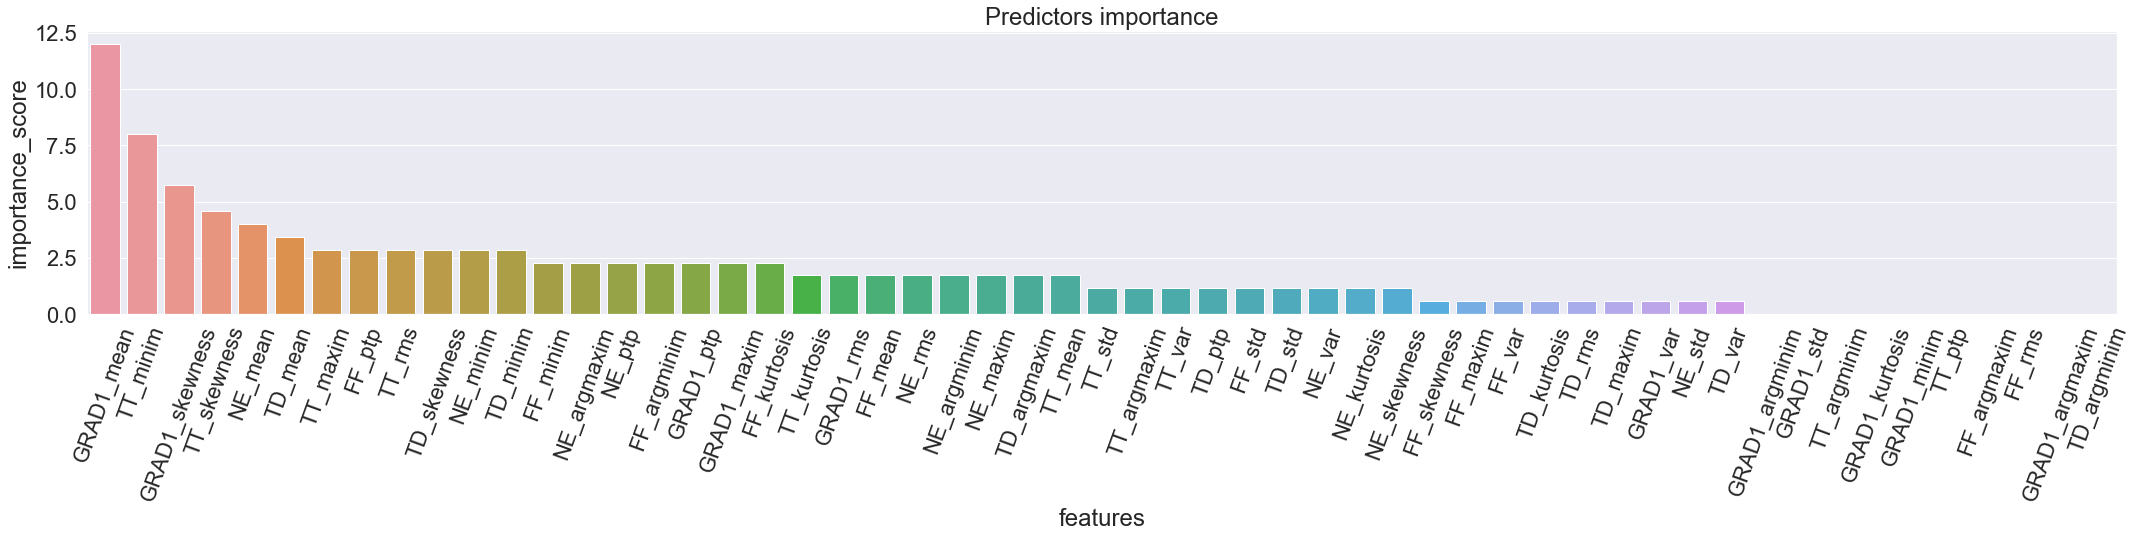

In [79]:
importances = best_model_ada.feature_importances_*100
feature_list = X.columns

sample_df = pd.DataFrame([])
feature_list
sample_df['features'] = feature_list
sample_df['importance_score'] = importances
sample_df = sample_df.sort_values(by = ['importance_score'],ascending=False)
plt.figure(figsize=(30,8))
sb.set(font_scale = 2)
sb.barplot(x='features',y='importance_score',data =sample_df).set(title="Predictors importance")
plt.xticks(rotation=70)
plt.tight_layout()

## Conclusions

In the regression analysis we constructed prediction models for two different times in the day and saw that we were able to predict the road surface temperature based on the given predictors with an estimated MSE of around 2.19 and 0.84 for RST_1400 and RST_2200, respectively. This suggests that we are better in predicting road surface temperatures in the evening/night rather than during the day. Furthermore, the most important features for predicting the current road surface temperature seems to be the current temperature and - depending on whether it is day or night - solar radiation is an important predictor.

From the classification analysis we observed that all the classification models works well in predicting the response variable. 
The best one is the SVM, which has an accuracy of about 94%. 
Thus, in future, it would be possible to aware people about the risk of driving in days with specific values of air temperature, dew point temperature, solar radiation, effective cloud cover, wind speed, without really knowing the road surface temperature. Moreover in the context of self-driving cars it is necessary to improve the performance of sensors in recognizing these weather situations and then study the behaviour of the car in terms of road-holding. 